In [119]:
import sys
import os
sys.path.append(f'/home/{os.environ["USER"]}/.conda/envs/esrgan/lib/python3.9/site-packages')
print(sys.path)

['/home/gsaltintas/dl/data/src', '/opt/anaconda3/lib/python39.zip', '/opt/anaconda3/lib/python3.9', '/opt/anaconda3/lib/python3.9/lib-dynload', '', '/home/gsaltintas/.local/lib/python3.9/site-packages', '/opt/anaconda3/lib/python3.9/site-packages', '/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions', '/home/gsaltintas/.ipython', '/home/gsaltintas/.conda/envs/esrgan/lib/python3.9/site-packages', '/home/gsaltintas/.conda/envs/esrgan/lib/python3.9/site-packages']


<AxesSubplot:>

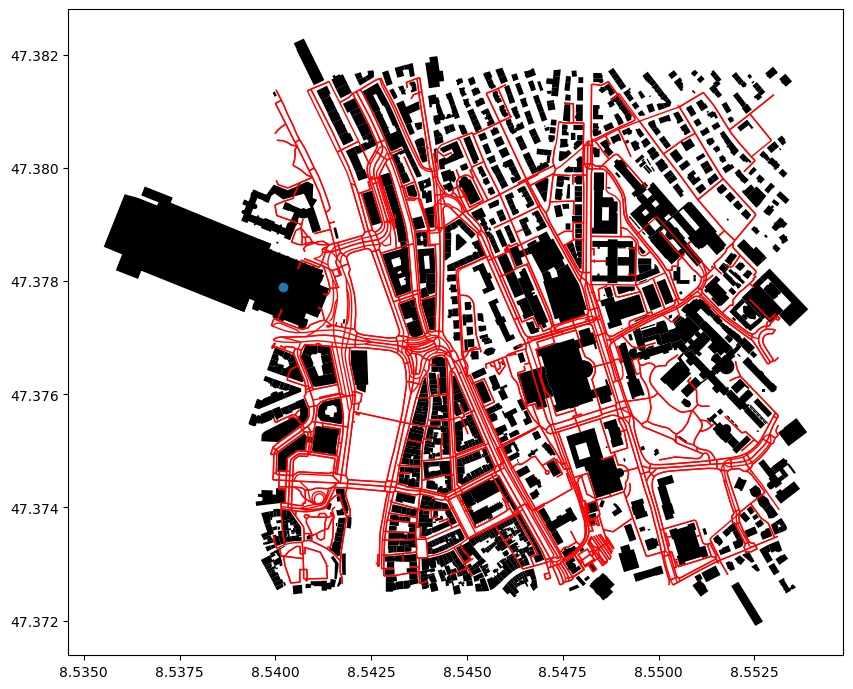

In [120]:
# install osmnx through pip, conda version is too old
# osmnx version should be 1.2.2 and shapely 2.0.0

# example plot using distance from a point (edges are not contained)
import osmnx as ox
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# ETH 47.377126, 8.5465143
bbox = ox.utils_geo.bbox_from_point((47.377126, 8.5465143), dist=500)

# EPFL 46.5186199,6.567573
# bbox = ox.utils_geo.bbox_from_point((46.5186199,6.567573), dist=500)

poly = ox.utils_geo.bbox_to_poly(*bbox)

buildings = ox.geometries_from_polygon(poly, tags={'building': True})
roads = ox.graph_from_polygon(poly)
nodes, edges = ox.graph_to_gdfs(roads)
# G = ox.graph_from_point((47.6710676, 9.0544013), dist=1000, network_type='all')

buildings.plot(ax=ax, facecolor='black', alpha=1)
edges.plot(ax=ax, linewidth=1, edgecolor='red')

In [121]:
# downloading from swisstopo using a GPS bounding box

import swisstopo_helpers as sw
from pathlib import Path

# from pyproj import Transformer

# # from gps to lv95
# trans = Transformer.from_crs(4326, 2056)

def transform_osm_to_sw(north, south, east, west):
  # [LONGITUDE_WEST, LAT_SOUTH, LONG_EAST, LAT_NORTH]
  return [west, south, east, north]

class Arguments(object):
  date_range = None
  bbox = None
  resolution = 0.1
#   save_dir = Path("./swisstopo").resolve().absolute()
  save_dir = Path("/data/swisstopo").resolve().absolute()

args = Arguments()

#use bounding box from above
args.bbox = transform_osm_to_sw(*bbox)
print(args.bbox)
url = sw.get_url(args)
print(url)
# sw.download_tifs(url, args)


[8.53987401306576, 47.37262939832253, 8.553154586934241, 47.38162260167746]
https://data.geo.admin.ch/api/stac/v0.9/collections/ch.swisstopo.swissimage-dop10/items?bbox=8.53987401306576,47.37262939832253,8.553154586934241,47.38162260167746


In [122]:
import pyproj
import shapely

def project_wsg_shape_to_csr(shape, target_crs: str = 'EPSG:2056', src_crs: str = 'epsg:4326'):
    """ projects src_crs (long/lat in case of Swisstopo or osmnx labels) format to target crs"""
    project = lambda x, y: pyproj.transform(
        pyproj.Proj(init=src_crs),
        pyproj.Proj(init=target_crs),
        x,
        y
    )
    return shapely.ops.transform(project, shape)


In [165]:
def create_raster_mask_rioxarray(entry: str, target_path: str, geoms: List, imshow: bool=False):
    """ 
    inspired by: https://gis.stackexchange.com/a/346899
    given the original tif image, creates masked file based on geometries specified by geoms 
    and saves it, projections are off for some
    """
    rds = rioxarray.open_rasterio(entry).isel(band=0)
    rds.values[:] = 1
    rds.rio.write_nodata(0, inplace=True)
    crs = rds.rio.crs#.to_string().lower()
    
#     geoms = list(map(lambda g: project_wsg_shape_to_csr(g, crs, 'epsg:4326'), geoms))
    # clip the raster to the mask
    if len(geoms) == 0:
        clipped = rds
    else:
        clipped = rds
        for i, g in enumerate(geoms):
            # todo: find a better alternative using geocube, 
            # eg: https://corteva.github.io/geocube/stable/examples/zonal_statistics.html
            tmp = rds.rio.clip(g, 'epsg:4326', drop=False)
            clipped += tmp * (i + 1)
#         clipped = rds.rio.clip(geoms, 'epsg:4326', drop=False)
#         clipped = rds.rio.clip(geoms, crs, drop=False)
    if imshow:
        clipped.plot.imshow()
    
    clipped.rio.to_raster(target_path, dtype="uint8")
    
def create_raster_mask(image, entry, target_path):
    """ saves generated cv2 image as a tif by copying the original file's metadata """
    img = Image.fromarray(image)
    img.tag_v2 = ImageFileDirectory_v2()
    with Image.open(entry) as first_geotiff:
        geot = GeoTiff(entry)
        patch_x_start_coords, patch_y_start_coords = geot.get_coords(0, 0)

        for to_copy in {34735, 34736, 34737, 33550, 1024, 1025, 2016, *range(2048, 2062),
                        *range(3072, 3096), *range(4096, 5000)}:
            if to_copy in first_geotiff.tag_v2:
                img.tag_v2[to_copy] = first_geotiff.tag_v2[to_copy]

    # change ModelTiepointTag; assume ModelPixelScaleTag stays the same
    img.tag_v2[33922] = (0.0, 0.0, 0.0, patch_x_start_coords, patch_y_start_coords, 0.0)  # i, j, k, x, y, z
    img.save(target_path, tiffinfo=img.tag_v2)
    


In [128]:
import geopandas as gpd
import numpy
import rioxarray
import xarray
import argparse
from geotiff import GeoTiff
import itertools
import numpy as np
import os
from PIL import Image
from PIL.TiffImagePlugin import ImageFileDirectory_v2
from sortedcontainers import SortedDict
from typing import List
import time

from geocube.api.core import make_geocube

%matplotlib inline

In [126]:
# # tried with geotif, something is off, the image is created off, in the middle of ocean
# target_path = t_path
# img = Image.fromarray(image)
# img.tag_v2 = ImageFileDirectory_v2()
# with Image.open(entry) as first_geotiff:
#     geot = GeoTiff(entry)
#     patch_x_start_coords, patch_y_start_coords = geot.get_coords(0, 0)
#     patch_x_start_coords, patch_y_start_coords = geot.tif_bBox[0]

#     for to_copy in {34735, 34736, 34737, 33550, 1024, 1025, 2016, *range(2048, 2062),
#                     *range(3072, 3096), *range(4096, 5000)}:
#         if to_copy in first_geotiff.tag_v2:
#             img.tag_v2[to_copy] = first_geotiff.tag_v2[to_copy]

# # change ModelTiepointTag; assume ModelPixelScaleTag stays the same
# img.tag_v2[33922] = (0.0, 0.0, 0.0, patch_x_start_coords, patch_y_start_coords, 0.0)  # i, j, k, x, y, z
# img.save('geo.tif', tiffinfo=img.tag_v2)


In [149]:
# ploting the segmentation map from a swissimage tiff file with api
import re
import json
from pathlib import Path
import numpy as np
import cv2
import io
import glob
from geojson import Feature, GeoJSON
import gc
import shutil

for entry in glob.glob(f"{args.save_dir}/swissimage-dop10*.tif"):
    # todo, maybe skip if there are multiple time variants of this image?
    entry = Path(entry)
    print(entry.name)
    image_id = re.search("swissimage-dop10_([0-9]+)_[0-9]+-[0-9]+", entry.name)[0]

    png_path = args.save_dir.joinpath(f'{image_id}_segmentation.png')
    t_path = args.save_dir.joinpath(f'{image_id}_segmentation.tif')
    
    if png_path.exists() and t_path.exists():
        print('File exists, skipping label generation.')
#         continue
    gc.collect()
    json_file = image_id + ".geojson"
    print(json_file)
    fileObject = open(args.save_dir.joinpath(json_file), "r")
    jsonContent = fileObject.read()
    geojson = GeoJSON(json.loads(jsonContent))
    coordList = geojson.geometry['coordinates'][0]
    fileObject.close()
    
    print(coordList)

    fig, ax = plt.subplots(figsize=(5, 10))

    # using the bounding box of the api TODO
    
    # might want to add some margin to also draw streets that go out of the image
    bbox = [coordList[1][1], coordList[0][1], coordList[0][0], coordList[3][0]]
    #       47.3684871,      47.3776072,      8.5375049,       8.5509303          sample values for zurich center

    # add relative margin to bounding box
    margin = 0.2
    deltaLatMargin = (bbox[1]-bbox[0]) * margin
    deltaLongMargin = (bbox[2]-bbox[3]) * margin
    bboxM = [bbox[0] - deltaLatMargin, bbox[1] + deltaLatMargin, bbox[2] + deltaLongMargin, bbox[3] - deltaLongMargin]

    poly = ox.utils_geo.bbox_to_poly(*bboxM)
    print(poly)
    
    try:
        # load osm infos TODO tags
        buildings = ox.geometries_from_polygon(poly, tags={'building': True})
        roadnetwork = ox.graph_from_polygon(poly)
        nodes, edges = ox.graph_to_gdfs(roadnetwork)
    except Exception as e:
        print('--'*15, '\n', e)
        continue

    # plot osm data TODO road width
    buildings.plot(ax=ax, color='black', facecolor='black', edgecolor='black', alpha=1)
    edges.plot(ax=ax, linewidth=1, edgecolor='red')

    # corner dots
    ax.scatter([x for (x,y) in coordList], [y for (x,y) in coordList], s=40, c="green", alpha=0.5)
    ax.scatter([x for (x,y) in coordList], [y for (x,y) in coordList], s=5, c="red", alpha=1)

    # crop
    ax.set_xlim((bboxM[2], bboxM[3]))
    ax.set_ylim((bboxM[0], bboxM[1]))
    ax.set_axis_off()

    # set image size
    resolution = 10000
    resolution = 3000
    inchSize = 103
    inchSize = 10
    dpi = resolution // inchSize
    
    # make figure resolution x resolution and remove margins from subplot
    fig.set_size_inches(inchSize, inchSize)
    fig.tight_layout(pad=-0.08)
    buffer = io.BytesIO()
    # fig.savefig(args.save_dir.joinpath(f'{image_id}_segmentation_raw.png'),dpi=dpi)
    # save to buffer to be loaded by opencv
    fig.savefig(buffer,dpi=dpi)

    # find angle to rotate the image by
    coords = np.array(coordList)
    xDir = coords[0] - coords[3]
    xDir /= [deltaLongMargin,deltaLatMargin]
    angle = - np.angle(xDir[0] + xDir[1]*1j)
    print(angle)

    # load image in opencv
    buffer.seek(0)
    image = cv2.imdecode(np.frombuffer(buffer.read(), dtype=np.uint8), cv2.IMREAD_ANYCOLOR)
    #image = cv2.imread(str(args.save_dir.joinpath(f'{image_id}_segmentation_raw.png')))

    yRes = (bboxM[1]-bboxM[0]) / resolution
    xRes = (bboxM[3]-bboxM[2]) / resolution

    # imspired by https://stackoverflow.com/questions/11627362/how-to-straighten-a-rotated-rectangle-area-of-an-image-using-opencv-in-python/48553593#48553593
    shape = ( image.shape[1], image.shape[0] )
    
    # rotate image around center and crop
    xCenter = int((coords[0][0] - bboxM[2]) / xRes)
    yCenter = int(resolution - (coords[0][1] - bboxM[0]) / yRes)

    matrix = cv2.getRotationMatrix2D( center=(xCenter, yCenter), angle=-angle / np.pi * 180, scale=1 )
    image = cv2.warpAffine( src=image, M=matrix, dsize=shape )

    # since we use the same margins on both sides, the top left corner is more or less the inverted bottom right corner
    image = image[xCenter:resolution - xCenter, yCenter:resolution - yCenter]
    # somehow image is flipped
    image = image[:, ::-1, :]
    
    # todo: add road geometry
    geoms = [list(buildings['geometry']), list(edges['geometry'])]
    create_raster_mask_rioxarray(entry, t_path, geoms, imshow=False)

    print(str(args.save_dir.joinpath(f'{image_id}_segmentation.png')))
    cv2.imwrite(str(png_path), image)
    plt.close()
    
    print(t_path)
    print()
    


swissimage-dop10_2022_2672-1250_8.39-47.40-8.41-47.41_2022-01-01.tif
File exists, skipping label generation.
swissimage-dop10_2022_2672-1250.geojson
[[8.405777, 47.405772], [8.405613, 47.396778], [8.392368, 47.396888], [8.392529, 47.405882], [8.405777, 47.405772]]
POLYGON ((8.3898794 47.4075708, 8.4084266 47.4075708, 8.4084266 47.394979199999995, 8.3898794 47.394979199999995, 8.3898794 47.4075708))
0.012229766045680018


/home/gsaltintas/.local/lib/python3.9/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
/home/gsaltintas/.local/lib/python3.9/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
/home/gsaltintas/.local/lib/python3.9/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


/data/swisstopo/swissimage-dop10_2022_2672-1250_segmentation.png
/data/swisstopo/swissimage-dop10_2022_2672-1250_segmentation.tif



/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/tmp/ipykernel_1930570/1571507424.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='/data/swisstopo/swissimage-dop10_2022_2677-1258_8.46-47.47-8.47-47.48_2022-01-01.tif'>
  im1 = Image.open(entry)


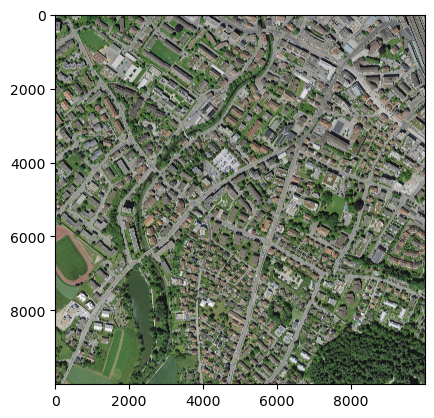

In [150]:
im1 = Image.open(entry)
plt.imshow(im1)

/home/gsaltintas/.local/lib/python3.9/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
/home/gsaltintas/.local/lib/python3.9/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


[0 1] [0 1]
0


/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion("0.0.0")


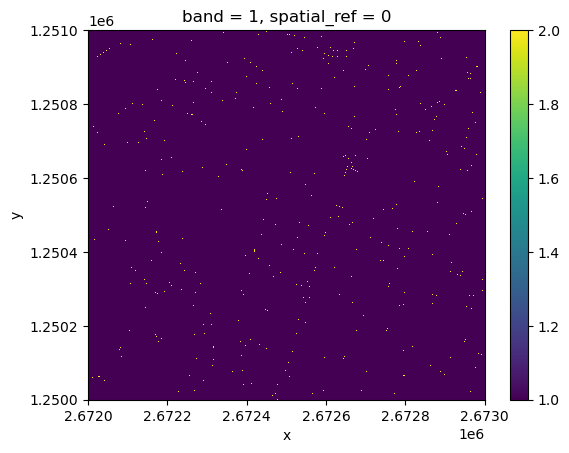

In [163]:
target_path = t_path
imshow = True
rds = rioxarray.open_rasterio(entry).isel(band=0)
rds.values[:] = 1
rds.rio.write_nodata(0, inplace=True)
crs = rds.rio.crs#.to_string().lower()

#     geoms = list(map(lambda g: project_wsg_shape_to_csr(g, crs, 'epsg:4326'), geoms))
# clip the raster to the mask
if len(geoms) == 0:
    clipped = rds
else:
    clipped = rds
    for i, g in enumerate([geoms[1]]):
        buildings = rds.rio.clip(g, 'epsg:4326', drop=False, all_touched=0)
        print(np.unique(buildings * (i+1)), np.unique(buildings))
        clipped += buildings * (i + 1)
        print(i)
#         , 'epsg:4326', drop=False)
#     clipped = rds.rio.clip(geoms, 'epsg:2056', drop=False)
if imshow:
    clipped.plot.imshow()

# clipped.rio.to_raster(target_path, dtype="uint8")

In [164]:
np.unique(clipped)

array([1, 2], dtype=uint8)

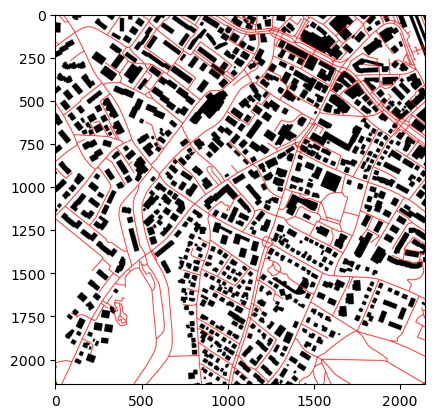

In [151]:
plt.imshow(Image.open(png_path))

Projection works very well
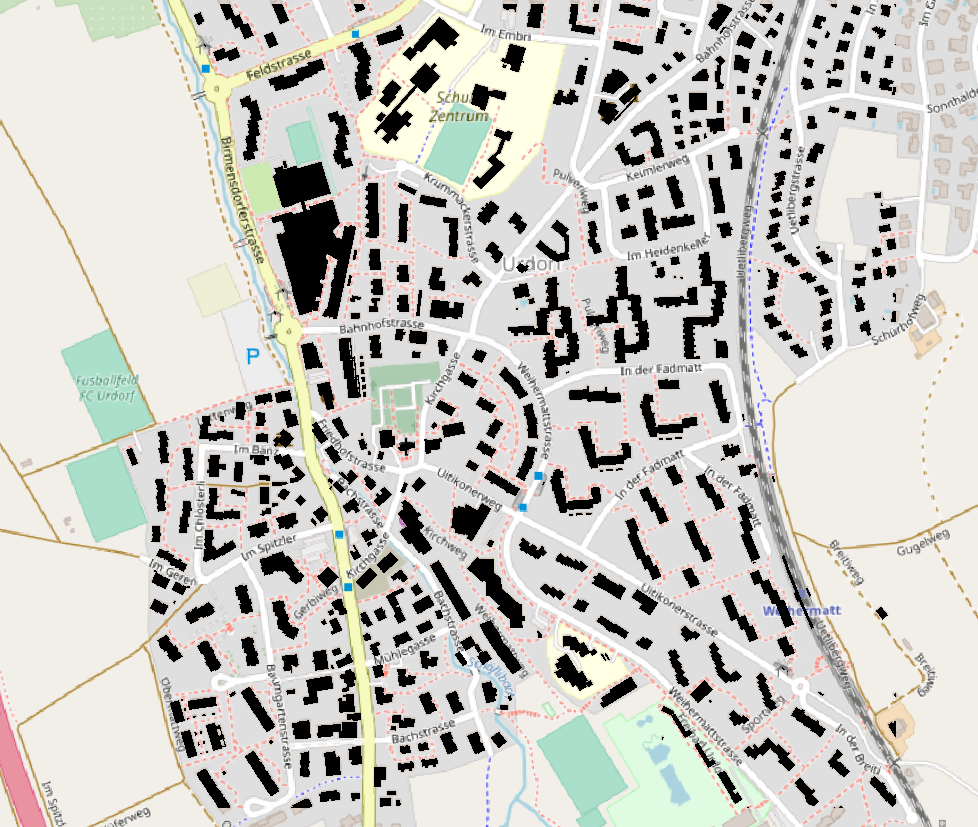

In [14]:
args.save_dir

PosixPath('/home/gsaltintas/dl/data/out/swisstopo')